In [1]:
import jax.numpy as jnp
from jax import tree_util as jtu, nn, vmap
from pymdp.jax.agent import Agent
import matplotlib.pyplot as plt
import seaborn as sns

from pymdp.jax.inference import smoothing_ovf


### Set up generative model and a sequence of observations. The A tensors, B tensors and observations are specified in such a way that  only later observations ($o_{t > 1}$) help disambiguate hidden states at earlier time points. This will demonstrate the importance of "smoothing" or retrospective inference

In [2]:
num_states = [3, 2]
num_obs = [3]

A_1 = jnp.array([[1.0, 1.0, 1.0], [0.0,  0.0,  1.]])
A_2 = jnp.array([[1.0, 1.0], [1., 0.]])

A_tensor = A_1[..., None] * A_2[:, None]

A_tensor /= A_tensor.sum(0)

A = [jnp.broadcast_to(A_tensor, (2, 2, 3, 2)) ]

# create two transition matrices, one for each state factor
B_1 = jnp.broadcast_to(
    jnp.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0]]), (2, 3, 3)
)

B_2 = jnp.broadcast_to(
        jnp.array([[0.0, 1.0], [1.0, 0.0]]), (2, 2, 2)
    )

B = [B_1[..., None], B_2[..., None]]

# for the single modality, a sequence over time of observations (one hot vectors)
obs = [jnp.broadcast_to(jnp.array([[1., 0.], # observation 0 is ambiguous with respect state factors
                                    [1., 0], # observation 0 is ambiguous with respect state factors
                                    [1., 0], # observation 0 is ambiguous with respect state factors
                                    [0., 1.]])[:, None], (4, 2, 2) )] # observation 1 provides information about exact state of both factors 
C = [jnp.zeros((2, 2))] # flat preferences
D = [jnp.ones((2, 3)) / 3., jnp.ones((2, 2)) / 2.] # flat prior
E = jnp.ones((2, 1))


2024-06-11 10:06:09.636131: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


### Construct the `Agent`

In [3]:
pA = None
pB = None

agents = Agent(
        A=A,
        B=B,
        C=C,
        D=D,
        E=E,
        pA=None,
        pB=None,
        policy_len=3,
        control_fac_idx=None,
        policies=None,
        gamma=16.0,
        alpha=16.0,
        use_utility=True,
        onehot_obs=True,
        action_selection="deterministic",
        sampling_mode="full",
        inference_algo="ovf",
        num_iter=16,
        learn_A=False,
        learn_B=False)


### Using `obs` and `policies`, pass in the arguments `outcomes`, `past_actions`, `empirical_prior` and `qs_hist` to `agent.infer_states(...)`

### Run first timestep of inference using `obs[0]`, no past actions, empirical prior set to actual prior, no qs_hist

In [5]:
prior = agents.D
qs_hist = None
action_hist = []
for t in range(len(obs[0])):
    first_obs = jtu.tree_map(lambda x: jnp.moveaxis(x[:t+1], 0, 1), obs)
    beliefs = agents.infer_states(first_obs, past_actions=None, empirical_prior=prior, qs_hist=qs_hist)
    actions = jnp.broadcast_to(agents.policies[0, 0], (2, 2))
    prior, qs_hist = agents.update_empirical_prior(actions, beliefs)
    action_hist.append(actions)

beliefs = jtu.tree_map(lambda x, y: jnp.concatenate([x[:, None], y], 1), agents.D, beliefs)
smoothed_beliefs = vmap(smoothing_ovf)(beliefs, agents.B, jnp.stack(action_hist, 1))

Text(0.5, 1.0, 'Filtered beliefs')

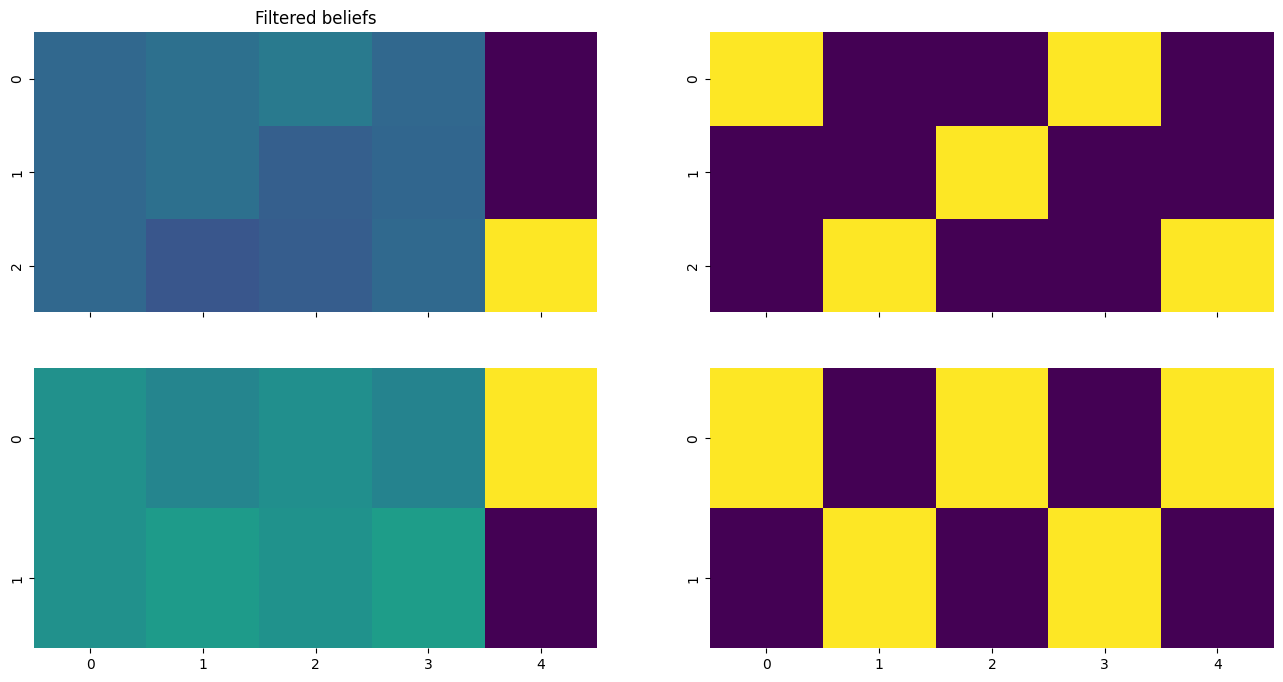

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)

sns.heatmap(beliefs[0][0].mT, ax=axes[0, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(beliefs[1][0].mT, ax=axes[1, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')

sns.heatmap(smoothed_beliefs[0][0][0].mT, ax=axes[0, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(smoothed_beliefs[1][0][0].mT, ax=axes[1, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')

axes[0, 0].set_title('Filtered beliefs')